# XG-Boost

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X_train = train.drop(columns='died')
X_test = test.drop(columns='died')
y_train = train.died
y_test = test.died

In [3]:
lasso_features = np.r_[1:16, 17:30, 31:37, 38:41, 43:46, 47, 49:54, 56:67, 
                       68:80, 82:94, 95:107, 109:112, 114:118, 119:121, 122, 
                       127:129, 130:137, 139:143, 144, 146:149, 150:157, 158,
                       161:164, 165, 167:169, 171:179, 180, 183:185, 186, 188,
                       191, 193, 195, 197, 199, 201, 203]

In [4]:
X_train = X_train.iloc[:, lasso_features]
X_test = X_test.iloc[:, lasso_features]

In [5]:
# XG-Boost doesn't accept characters such as <, > in feature names
X_train.rename(columns={'numbedscategory_<100': 'numbedscategory_lt_100', 
                        'numbedscategory_>= 500': 'numbedscategory_gte_500'}, 
               inplace=True)
X_test.rename(columns={'numbedscategory_<100': 'numbedscategory_lt_100', 
                       'numbedscategory_>= 500': 'numbedscategory_gte_500'}, 
              inplace=True)

### Train baseline XG-Boost with default parameters

In [6]:
xgb_mod = xgb.XGBClassifier(random_state=670).fit(X_train, y_train)

train_precision, train_recall, _ = (
    precision_recall_curve(y_train, xgb_mod.predict_proba(X_train)[:, 1])
)
test_precision, test_recall, _ = (
    precision_recall_curve(y_test, xgb_mod.predict_proba(X_test)[:, 1])
)

train_auprc = auc(train_recall, train_precision)
test_auprc = auc(test_recall, test_precision)

print(round(train_auprc, 3))
print(round(test_auprc, 3))

0.998
0.562


In [7]:
# Set up k-fold validation set
k_folds = KFold(n_splits=5, shuffle=True, random_state=670)
splits = list(k_folds.split(X_train, y_train))

param_grid = {'n_estimators': range(100, 600, 100),
              'learning_rate': [0.001, 0.01, 0.1]}

xgb_mod.set_params(**{'max_depth': 1})
grid_search = GridSearchCV(estimator=xgb_mod,
                           param_grid=param_grid,
                           scoring='average_precision',
                           cv=splits,
                           n_jobs=-1)
grid_search.fit(X_train, y_train) 

# Get best parameters from Grid Search
print(grid_search.best_params_)

train_precision, train_recall, _ = (
    precision_recall_curve(y_train, grid_search.predict_proba(X_train)[:, 1])
)
test_precision, test_recall, _ = (
    precision_recall_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
)

train_auprc = auc(train_recall, train_precision)
test_auprc = auc(test_recall, test_precision)

print(round(train_auprc, 3))
print(round(test_auprc, 3))

{'learning_rate': 0.1, 'n_estimators': 500}
0.63
0.565


In [8]:
def plot_validation_curves(model, param_range, data, target, param_name, 
                           scoring, cv, ylabel):
    
    train_scores, valid_scores = validation_curve(model, 
                                                  data, 
                                                  target, 
                                                  param_name=param_name, 
                                                  param_range=param_range,
                                                  scoring=scoring,
                                                  cv=cv)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.title(f'Validation Curve with {param_name}')
    plt.xlabel(f'{param_name}')
    plt.ylabel(ylabel)
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(
        param_range, 
        train_scores_mean, 
        label="Training score", 
        color="darkorange", 
        lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.plot(
        param_range, 
        valid_scores_mean, 
        label="Cross-validation score", 
        color="navy", 
        lw=lw
    )
    plt.fill_between(
        param_range,
        valid_scores_mean - valid_scores_std,
        valid_scores_mean + valid_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.show()

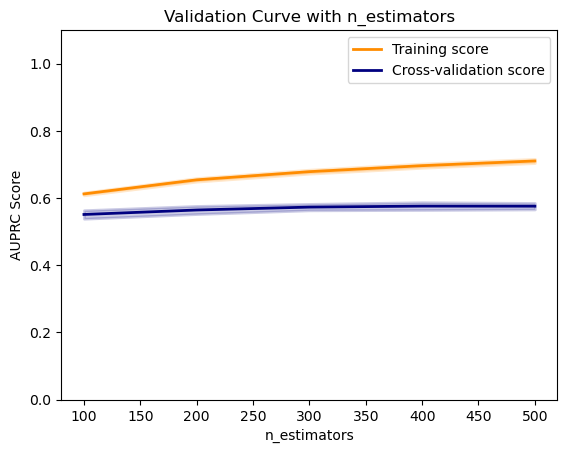

In [9]:
# Plot validation curves for n_estimators
plot_validation_curves(model=xgb_mod, 
                       param_range=range(100, 600, 100), 
                       data=X_train, 
                       target=y_train, 
                       param_name='n_estimators', 
                       scoring='average_precision', 
                       cv=splits, 
                       ylabel='AUPRC Score')

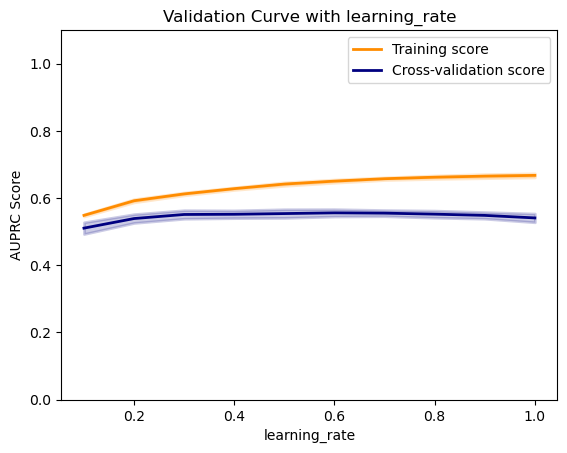

In [10]:
# Plot validation curves for learning rate
plot_validation_curves(model=xgb_mod, 
                       param_range=np.arange(0.1, 1.1, 0.1), 
                       data=X_train, 
                       target=y_train, 
                       param_name='learning_rate', 
                       scoring='average_precision', 
                       cv=splits, 
                       ylabel='AUPRC Score')

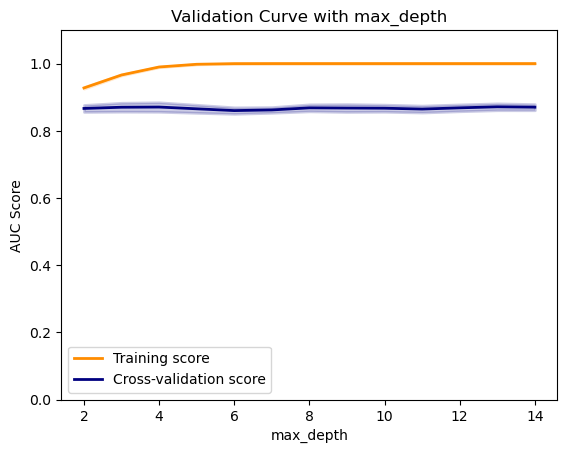

In [11]:
# Plot validation curves for max depth
plot_validation_curves(model=xgb_mod, 
                       param_range=range(2, 15, 1), 
                       data=X_train, 
                       target=y_train, 
                       param_name='max_depth', 
                       scoring='roc_auc', 
                       cv=splits, 
                       ylabel='AUC Score')

### Evaluate final model

In [12]:
# Create function to compute optimal F-beta score using threshold tuning
def compute_metrics(y_pred_prob, y_true):
    
    thresholds = np.arange(0, 1.01, 0.01)
    results = pd.DataFrame(columns=['threshold', 'precision', 'recall', 
                                    'f-score'])
    
    for threshold in thresholds:
        y_pred = np.where(y_pred_prob >= threshold, 1, 0)
          
        # Compute precision
        precision = precision_score(y_true, y_pred)
        
        # Compute recall
        recall = recall_score(y_true, y_pred)
        
        # Compute F-beta score
        f_score = fbeta_score(y_true, y_pred, beta=2)
        
        results = results.append({'threshold': threshold,
                                  'precision': precision,
                                  'recall': recall,
                                  'f-score': f_score}, 
                                 ignore_index=True)
        
    return results.loc[results['f-score'] == results['f-score'].max(), :]

In [13]:
train_pred_probs = grid_search.predict_proba(X_train)[:, 1]
test_pred_probs = grid_search.predict_proba(X_test)[:, 1]

train_results = compute_metrics(train_pred_probs, y_train)
test_results = compute_metrics(test_pred_probs, y_test)

print(train_results)
print(test_results)

    threshold  precision    recall   f-score
13       0.13   0.367512  0.807595  0.651552
    threshold  precision   recall   f-score
14       0.14   0.357482  0.74321  0.611292
